<H1>Predictiong flight delays - Machine Learning</H1>

<B>Import the libraries

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import csv
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
import warnings; warnings.simplefilter('ignore')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import dummy
from sklearn import preprocessing
from sklearn import linear_model

In [2]:
all_files = ["2016_01.csv"]
li = []
columns_to_keep = ['DAY_OF_MONTH','DAY_OF_WEEK','MONTH','ORIGIN','DEST','CRS_DEP_TIME','DEP_DELAY','CRS_ARR_TIME']
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0,error_bad_lines=False)
    # Filter on ExpressJet
    df = df[df['UNIQUE_CARRIER'] == 'B6']
    # Leaving only non-canceled flights
    df = df[(df['CANCELLED'] == 0)]
    # Leaving only non-diverted flights
    df = df[(df['DIVERTED'] == 0)]
    # Filter out non-delayed flights < 0 DEP_DELAY
    df = df[(df['DEP_DELAY'] > 0)]
    # Keeping only necessary columns
    df = df[columns_to_keep]
    li.append(df)
df = pd.concat(li, axis=0, ignore_index=True)
del li

In [3]:
df.head(5)

,DAY_OF_MONTH,DAY_OF_WEEK,MONTH,ORIGIN,DEST,CRS_DEP_TIME,DEP_DELAY,CRS_ARR_TIME
0,1,5,1,SWF,MCO,1810,8.0,2110
1,1,5,1,LGB,OAK,2015,12.0,2132
2,1,5,1,JFK,PBI,805,2.0,1105
3,1,5,1,PBI,JFK,1716,11.0,2000
4,1,5,1,FLL,BDL,826,4.0,1116


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10294 entries, 0 to 10293
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DAY_OF_MONTH  10294 non-null  int64  
 1   DAY_OF_WEEK   10294 non-null  int64  
 2   MONTH         10294 non-null  int64  
 3   ORIGIN        10294 non-null  object 
 4   DEST          10294 non-null  object 
 5   CRS_DEP_TIME  10294 non-null  int64  
 6   DEP_DELAY     10294 non-null  float64
 7   CRS_ARR_TIME  10294 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 643.5+ KB


In [5]:
# Type conversion
df['DAY_OF_WEEK'] = df['DAY_OF_WEEK'].astype(int)
df['DAY_OF_MONTH'] = df['DAY_OF_MONTH'].astype(int)
df['CRS_DEP_TIME'] = df['CRS_DEP_TIME'].astype(int)
df['DEP_DELAY'] = df['DEP_DELAY'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10294 entries, 0 to 10293
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   DAY_OF_MONTH  10294 non-null  int64 
 1   DAY_OF_WEEK   10294 non-null  int64 
 2   MONTH         10294 non-null  int64 
 3   ORIGIN        10294 non-null  object
 4   DEST          10294 non-null  object
 5   CRS_DEP_TIME  10294 non-null  int64 
 6   DEP_DELAY     10294 non-null  int64 
 7   CRS_ARR_TIME  10294 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 643.5+ KB


In [6]:
# Filling factor
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(df.shape[0]-missing_df['missing values'])/df.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,DAY_OF_MONTH,0,100.0
1,DAY_OF_WEEK,0,100.0
2,MONTH,0,100.0
3,ORIGIN,0,100.0
4,DEST,0,100.0
5,CRS_DEP_TIME,0,100.0
6,DEP_DELAY,0,100.0
7,CRS_ARR_TIME,0,100.0


<H2>Model n°1: One airline, one airport</H2>

In [7]:
df1 = df[df['ORIGIN'] == 'JFK']
df1 = df1.drop('ORIGIN',axis=1)
df1.shape

(1633, 7)

In [8]:
df1

,DAY_OF_MONTH,DAY_OF_WEEK,MONTH,DEST,CRS_DEP_TIME,DEP_DELAY,CRS_ARR_TIME
2,1,5,1,PBI,805,2,1105
8,1,5,1,JAX,1452,80,1735
21,1,5,1,PBI,1810,8,2110
25,1,5,1,MSY,1455,89,1736
27,1,5,1,HOU,1329,1,1639
...,...,...,...,...,...,...,...
10231,3,7,1,JAX,2032,24,2312
10269,24,7,1,SLC,2059,13,19
10274,24,7,1,SAN,1646,8,2004
10281,24,7,1,BOS,1359,63,1505


In [9]:
df1 = pd.get_dummies(df1, columns = ['DEST'])
df1.head(5)

,DAY_OF_MONTH,DAY_OF_WEEK,MONTH,CRS_DEP_TIME,DEP_DELAY,CRS_ARR_TIME,DEST_ABQ,DEST_AUS,DEST_BOS,DEST_BQN,...,DEST_SAV,DEST_SEA,DEST_SFO,DEST_SJC,DEST_SJU,DEST_SLC,DEST_SMF,DEST_SRQ,DEST_SYR,DEST_TPA
2,1,5,1,805,2,1105,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,5,1,1452,80,1735,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21,1,5,1,1810,8,2110,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25,1,5,1,1455,89,1736,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27,1,5,1,1329,1,1639,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
X = df1.drop('DEP_DELAY',axis=1)
y = df1.DEP_DELAY
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) 

In [11]:
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

<H3>Model n°1 - Linear Regression - Implementation

In [12]:
# On crée un modèle de régression linéaire
lr = linear_model.LinearRegression()

# On entraîne ce modèle sur les données d'entrainement
lr.fit(X_train_std,y_train)

# On récupère l'erreur de norme 2 sur le jeu de données test comme baseline
baseline_error = np.mean((lr.predict(X_test_std) - y_test) ** 2)

print(baseline_error)

1486.1839609371352


In [13]:
pred_train_lr= lr.predict(X_train_std)
print(np.sqrt(mean_squared_error(y_train,pred_train_lr)))
print(r2_score(y_train, pred_train_lr))

pred_test_lr= lr.predict(X_test_std)
print(np.sqrt(mean_squared_error(y_test,pred_test_lr))) 
print(r2_score(y_test, pred_test_lr))

41.786527103547705
0.06841794118823574
38.55105654761145
-0.00999824846215347


In [14]:
mse = mean_squared_error(pred_test_lr, y_test)
print("MSE =", mse)

MSE = 1486.1839609371357


<H3>Model n°1 - Linear Regression - Result</H3>

In [15]:
icount = 0
for i, val in enumerate(y_test):
    if abs(val-pred_test_lr[i]) > 15: icount += 1
'Number of predictions where the differences with real values is greater than 15 minutes: {:.2f}%'.format(icount / len(pred_test_lr) * 100)

'Number of predictions where the differences with real values is greater than 15 minutes: 66.33%'

In [16]:
'Delay = {:.2f} min'.format(np.sqrt(mse))

'Delay = 38.55 min'

In [17]:
del df1

<H2>Model n°2: One airline, all airports</H2>

In [18]:
df.to_csv('flights_B6.csv')

In [19]:
df = pd.get_dummies(df, columns = ['DEST'])
df = pd.get_dummies(df, columns = ['ORIGIN'])
df.head(5)

,DAY_OF_MONTH,DAY_OF_WEEK,MONTH,CRS_DEP_TIME,DEP_DELAY,CRS_ARR_TIME,DEST_ABQ,DEST_ALB,DEST_AUS,DEST_BDL,...,ORIGIN_SJC,ORIGIN_SJU,ORIGIN_SLC,ORIGIN_SMF,ORIGIN_SRQ,ORIGIN_STT,ORIGIN_STX,ORIGIN_SWF,ORIGIN_SYR,ORIGIN_TPA
0,1,5,1,1810,8,2110,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,5,1,2015,12,2132,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,5,1,805,2,1105,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,5,1,1716,11,2000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,5,1,826,4,1116,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


<B>Split data</B><BR>
Split the data set into train and test sets (use X_train, X_test, y_train, y_test), with the first 70% of the data for training and the remaining for testing.

In [20]:
X = df.drop('DEP_DELAY',axis=1)
y = df.DEP_DELAY
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) 

<B>Standardisation

In [21]:
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

<H3>Linear regression</H3>

<H3>Model n°2 - Linear Regression - Implementation

<b>Baseline model</b><BR>
We can now run our baseline model. This will give us a measure of comparison for the ridge and lasso model. Our metric is the mean squared error. Below is the code with the results of the model.

In [22]:
# On crée un modèle de régression linéaire
lr = linear_model.LinearRegression()

# On entraîne ce modèle sur les données d'entrainement
lr.fit(X_train_std,y_train)

# On récupère l'erreur de norme 2 sur le jeu de données test comme baseline
baseline_error = np.mean((lr.predict(X_test_std) - y_test) ** 2)

print(baseline_error)

2359.7400988796708


In [23]:
pred_train_lr= lr.predict(X_train_std)
print(np.sqrt(mean_squared_error(y_train,pred_train_lr)))
print(r2_score(y_train, pred_train_lr))

pred_test_lr= lr.predict(X_test_std)
print(np.sqrt(mean_squared_error(y_test,pred_test_lr))) 
print(r2_score(y_test, pred_test_lr))

46.897555398610166
0.04482486672819874
48.5771561423646
-0.0015630117710301317


The above output shows that the RMSE, one of the two evaluation metrics, is 54.23 for train data and 54.31 for test data. On the other hand, R-squared value is 3.29 percent for train data and 2.55 percent for test data.

In [24]:
mse = mean_squared_error(pred_test_lr, y_test)
print("MSE =", mse)

MSE = 2359.7400988796708


<H3>Model n°2 - Linear Regression - Results

In [25]:
icount = 0
for i, val in enumerate(y_test):
    if abs(val-pred_test_lr[i]) > 15: icount += 1
'Number of predictions where the differences with real values is greater than 15 minutes: {:.2f}%'.format(icount / len(pred_test_lr) * 100)

'Number of predictions where the differences with real values is greater than 15 minutes: 71.58%'

In [26]:
'Delay = {:.2f} min'.format(np.sqrt(mse))

'Delay = 48.58 min'

<H3>Model n°2 - Ridge Regression - Implementation</H3>

<B>Best alpha</B><BR>
Alpha is an important factor in regularization. It defines Ridge shrinkage or regularization strength. The higher value means the stronger regularization. We don't know which value works efficiently for our regularization method. Thus we'll figure out the best alpha value by checking the model accuracy with setting multiple alpha values.

In [27]:
n_alphas = 100
alphas = np.logspace(-3, 7, n_alphas)

In [28]:
ridge = linear_model.Ridge()

coefs = []
errors = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train_std, y_train)
    coefs.append(ridge.coef_)
    errors.append([baseline_error, np.mean((ridge.predict(X_test_std) - y_test) ** 2)])

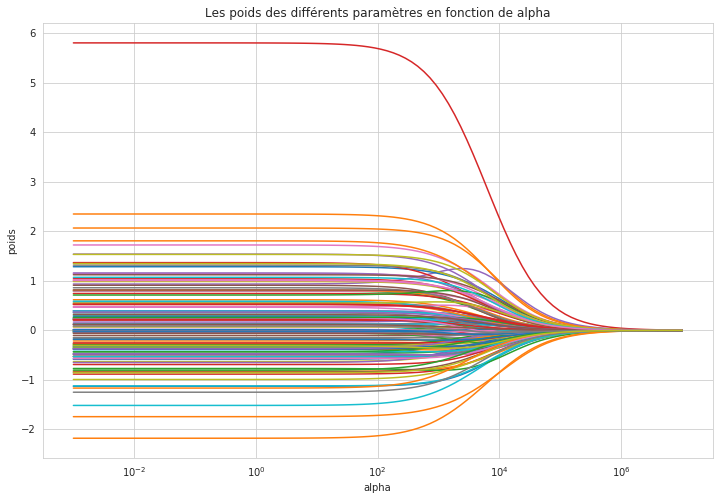

In [29]:
plt.figure(figsize=(12,8))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('poids')
plt.title('Les poids des différents paramètres en fonction de alpha')
plt.axis('tight')
plt.show()

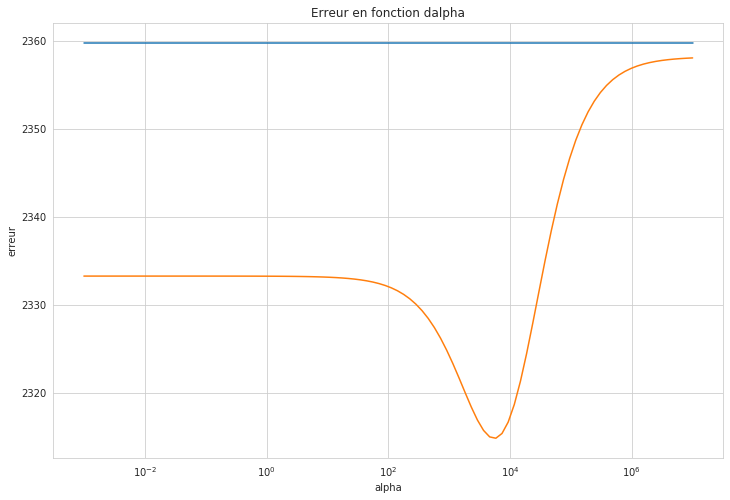

In [30]:
plt.figure(figsize=(12,8))
ax = plt.gca()
ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('erreur')
plt.title('Erreur en fonction d''alpha')
plt.axis('tight')
plt.show()

In [31]:
min(errors)

[2359.7400988796708, 2314.818064882566]

<H3>Model n°2 - Cross-validation with RidgeCV</H3>

RidgeCV is built-in cross-validation class. In this model, we can set all alpha values and get the efficient alpha value in a set.

In [32]:
ridge_cv=RidgeCV(alphas=alphas, store_cv_values=True)
ridge_mod = ridge_cv.fit(X_train_std,y_train)
print(ridge_mod.alpha_)

4641.588833612782


In [33]:
rr = Ridge(alpha=4641.59)
rr.fit(X_train_std, y_train) 
pred_train_rr= rr.predict(X_train_std)
print(np.sqrt(mean_squared_error(y_train,pred_train_rr)))
print(r2_score(y_train, pred_train_rr))

pred_test_rr= rr.predict(X_test_std)
print(np.sqrt(mean_squared_error(y_test,pred_test_rr))) 
print(r2_score(y_test, pred_test_rr))

46.9414919396971
0.0430342936452498
48.11412140949894
0.01743967337604213


In [34]:
y_pred = ridge_mod.predict(X_test_std)
score = ridge_mod.score(X_test_std,y_test)

In [35]:
mse = mean_squared_error(y_test,y_pred)
print("MSE =", mse)

MSE = 2314.9686795106495


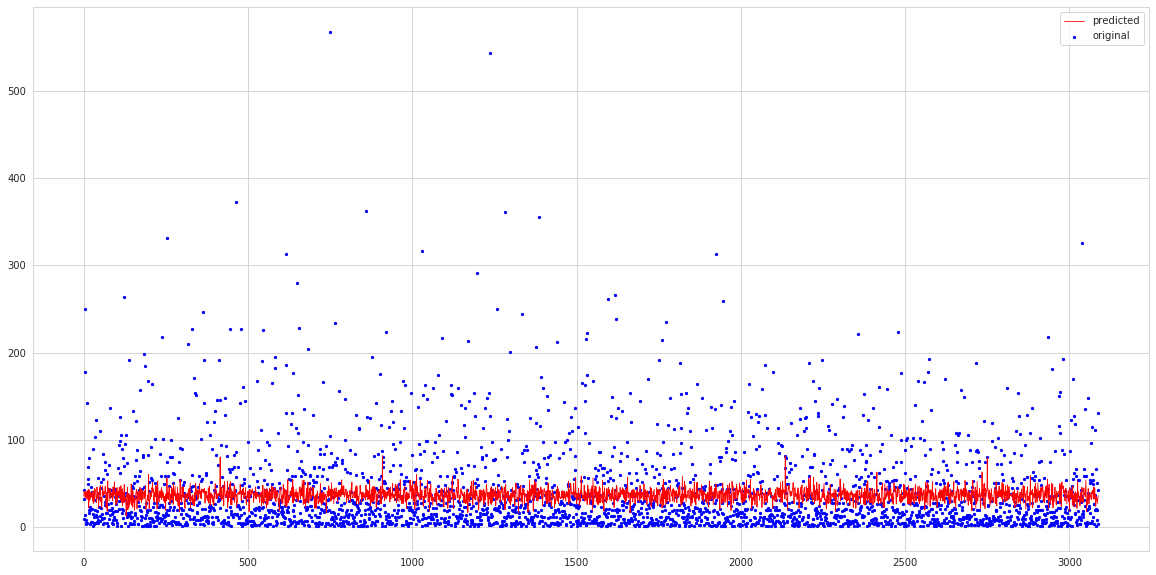

In [36]:
plt.figure(figsize=(20, 10))
x_ax = range(len(X_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, y_pred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

In [37]:
icount = 0
for i, val in enumerate(y_test):
    if abs(val-pred_test_lr[i]) > 15: icount += 1
'Number of predictions where the differences with real values is greater than 15 minutes: {:.2f}%'.format(icount / len(pred_test_lr) * 100)

'Number of predictions where the differences with real values is greater than 15 minutes: 71.58%'

In [38]:
'Delay = {:.2f} min'.format(np.sqrt(mse))

'Delay = 48.11 min'

<H3>Model n°2 - Lasso regression - Implementation</H3>

Apply Lasso regression on the training set with the regularization parameter lambda = 0.5 and print the 
R^2-score for the training and test set.

In [39]:
n_alphas = 50
alphas = np.logspace(-4, 2, n_alphas)
lasso = linear_model.Lasso(fit_intercept=False)

coefs = []
errors = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train_std, y_train)
    coefs.append(lasso.coef_)
    errors.append([baseline_error, np.mean((lasso.predict(X_test_std) - y_test) ** 2)])

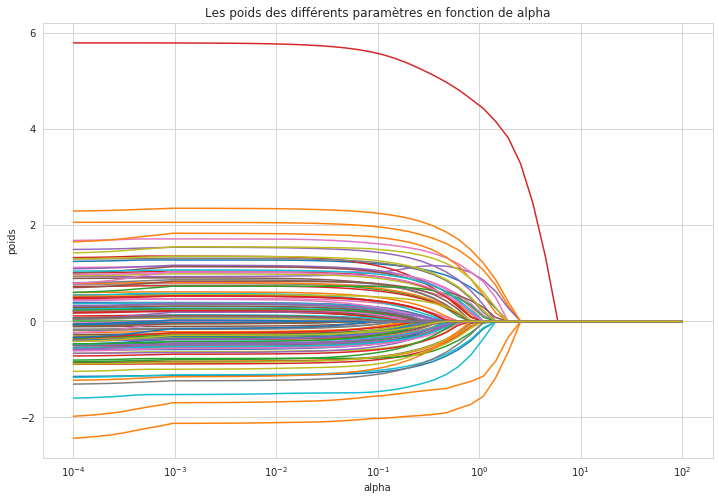

In [40]:
plt.figure(figsize=(12,8))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('poids')
plt.title('Les poids des différents paramètres en fonction de alpha')
plt.axis('tight')
plt.show()

In [41]:
min(errors)

[2359.7400988796708, 3748.42204966778]

<H3>Model n°2 - Lasso regression - Lasso CV</H3>

LassoCV applies cross-validation method to find out the best model. We'll set multiple alpha values and to train the model.

In [42]:
alphas = [0.5,0.6,0.7,0.8,0.9,1]
lassocv = LassoCV(alphas=alphas, cv=5).fit(X_train_std,y_train)
print(lassocv.alpha_)

0.6


In [43]:
score = lassocv.score(X_train_std,y_train)
y_pred = lassocv.predict(X_test_std)

In [44]:
mse = mean_squared_error(y_test,y_pred)
print("MSE =", mse)

MSE = 2307.3883863761075


In [45]:
model_lasso = Lasso(alpha=0.6)
model_lasso.fit(X_train_std, y_train) 
pred_train_lasso= model_lasso.predict(X_train_std)
print(np.sqrt(mean_squared_error(y_train,pred_train_lasso)))
print(r2_score(y_train, pred_train_lasso))

pred_test_lasso= model_lasso.predict(X_test_std)
print(np.sqrt(mean_squared_error(y_test,pred_test_lasso))) 
print(r2_score(y_test, pred_test_lasso))

47.039407286388595
0.03903785675174609
48.03528272401556
0.02065703647552608


Finally, we can visualize the result in a plot.

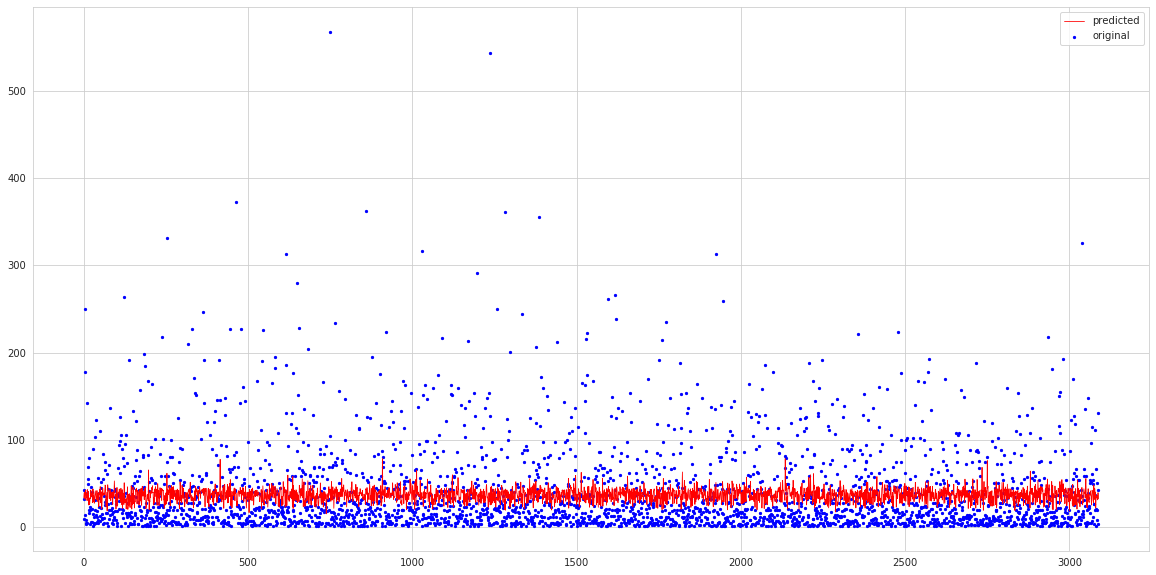

In [46]:
plt.figure(figsize=(20, 10))
x_ax = range(len(X_test_std))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, y_pred,lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

<H3>Model n°2 - Lasso regression - Results</H3>

In [47]:
icount = 0
for i, val in enumerate(y_test):
    if abs(val-pred_test_lr[i]) > 15: icount += 1
'Number of predictions where the differences with real values is greater than 15 minutes: {:.2f}%'.format(icount / len(pred_test_lr) * 100)

'Number of predictions where the differences with real values is greater than 15 minutes: 71.58%'

In [48]:
'Delay = {:.2f} min'.format(np.sqrt(mse))

'Delay = 48.04 min'

<H2> Model n°3: All airlines, one airport</H2>

In [49]:
all_files = ["2016_01.csv"]
li = []
columns_to_keep = ['DAY_OF_MONTH','DAY_OF_WEEK','MONTH','UNIQUE_CARRIER','DEST','CRS_DEP_TIME','DEP_DELAY','CRS_ARR_TIME']
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0,error_bad_lines=False)
    # Filter on ExpressJet
    df = df[df['ORIGIN'] == 'JFK']
    # Leaving only non-canceled flights
    df = df[(df['CANCELLED'] == 0)]
    # Leaving only non-diverted flights
    df = df[(df['DIVERTED'] == 0)]
    # Filter out non-delayed flights < 0 DEP_DELAY
    df = df[(df['DEP_DELAY'] > 0)]
    # Keeping only necessary columns
    df = df[columns_to_keep]
    li.append(df)
df = pd.concat(li, axis=0, ignore_index=True)
del li

In [50]:
# Type conversion
df['DAY_OF_WEEK'] = df['DAY_OF_WEEK'].astype(int)
df['DAY_OF_MONTH'] = df['DAY_OF_MONTH'].astype(int)
df['CRS_DEP_TIME'] = df['CRS_DEP_TIME'].astype(int)
df['DEP_DELAY'] = df['DEP_DELAY'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3102 entries, 0 to 3101
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   DAY_OF_MONTH    3102 non-null   int64 
 1   DAY_OF_WEEK     3102 non-null   int64 
 2   MONTH           3102 non-null   int64 
 3   UNIQUE_CARRIER  3102 non-null   object
 4   DEST            3102 non-null   object
 5   CRS_DEP_TIME    3102 non-null   int64 
 6   DEP_DELAY       3102 non-null   int64 
 7   CRS_ARR_TIME    3102 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 194.0+ KB


In [51]:
# Filling factor
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(df.shape[0]-missing_df['missing values'])/df.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,DAY_OF_MONTH,0,100.0
1,DAY_OF_WEEK,0,100.0
2,MONTH,0,100.0
3,UNIQUE_CARRIER,0,100.0
4,DEST,0,100.0
5,CRS_DEP_TIME,0,100.0
6,DEP_DELAY,0,100.0
7,CRS_ARR_TIME,0,100.0


In [52]:
df = pd.get_dummies(df, columns = ['DEST'])
df = pd.get_dummies(df, columns = ['UNIQUE_CARRIER'])
df.head(5)

,DAY_OF_MONTH,DAY_OF_WEEK,MONTH,CRS_DEP_TIME,DEP_DELAY,CRS_ARR_TIME,DEST_ABQ,DEST_ATL,DEST_AUS,DEST_BOS,...,DEST_SRQ,DEST_STT,DEST_SYR,DEST_TPA,UNIQUE_CARRIER_AA,UNIQUE_CARRIER_AS,UNIQUE_CARRIER_B6,UNIQUE_CARRIER_DL,UNIQUE_CARRIER_HA,UNIQUE_CARRIER_VX
0,2,6,1,1825,64,2150,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,3,7,1,1825,31,2150,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,4,1,1,1825,46,2150,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,5,2,1,1820,6,2142,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,6,3,1,1820,2,2142,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [53]:
X = df.drop('DEP_DELAY',axis=1)
y = df.DEP_DELAY
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) 

In [54]:
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

<H3>Model n°3 - Ridge regression - Implementation</H3>

In [55]:
n_alphas = 100
alphas = np.logspace(-3, 7, n_alphas)

In [56]:
ridge_cv=RidgeCV(alphas=alphas, store_cv_values=True)
ridge_mod = ridge_cv.fit(X_train_std,y_train)
print(ridge_mod.alpha_)

1450.8287784959402


In [57]:
rr = Ridge(alpha=1450.83)
rr.fit(X_train_std, y_train) 
pred_train_rr= rr.predict(X_train_std)
print(np.sqrt(mean_squared_error(y_train,pred_train_rr)))
print(r2_score(y_train, pred_train_rr))

pred_test_rr= rr.predict(X_test_std)
print(np.sqrt(mean_squared_error(y_test,pred_test_rr))) 
print(r2_score(y_test, pred_test_rr))

50.67704058273413
0.06471989343504658
60.08809597102533
0.017281494856386193


In [58]:
y_pred = ridge_mod.predict(X_test_std)
score = ridge_mod.score(X_test_std,y_test)

In [59]:
mse = mean_squared_error(y_test,y_pred)
print("MSE =", mse)

MSE = 3610.5792800107915


<H3>Model n°3 - Ridge regression - Results</H3>

In [60]:
icount = 0
for i, val in enumerate(y_test):
    if abs(val-pred_test_lr[i]) > 15: icount += 1
'Number of predictions where the differences with real values is greater than 15 minutes: {:.2f}%'.format(icount / len(pred_test_lr) * 100)

'Number of predictions where the differences with real values is greater than 15 minutes: 22.73%'

In [61]:
'Delay = {:.2f} min'.format(np.sqrt(mse))

'Delay = 60.09 min'

<H3>Model n°3 - Lasso - Implementation</H3>

In [62]:
alphas = [1,1.1,1.2,1.3,1.4,1.5]
lassocv = LassoCV(alphas=alphas, cv=5).fit(X_train_std,y_train)
print(lassocv.alpha_)

1.3


In [63]:
score = lassocv.score(X_train_std,y_train)
y_pred = lassocv.predict(X_test_std)

In [64]:
mse = mean_squared_error(y_test,y_pred)
print("MSE =", mse)

MSE = 3594.8869011801394


<H3>Model n°3 - Lasso - Results</H3>

In [65]:
'Delay = {:.2f} min'.format(np.sqrt(mse))

'Delay = 59.96 min'

<H2>Performance evaluation</H2>

In [66]:
y_pred_random = np.random.randint(np.min(y), np.max(y), y_test.shape)

In [67]:
mse = mean_squared_error(y_test, y_pred_random)
print("MSE =", mse)

MSE = 259286.23308270678


In [68]:
'Ecart = {:.2f} min'.format(np.sqrt(mse))

'Ecart = 509.20 min'

<H3>Comparison with a random model</H3>

In [69]:
dum = dummy.DummyRegressor(strategy='mean')

# Entraînement
dum.fit(X_train_std, y_train)

# Prédiction sur le jeu de test
y_pred_dum = dum.predict(X_test_std)

In [70]:
# Evaluate
mse = mean_squared_error(y_test, y_pred_dum)
print("MSE =", mse)

MSE = 3676.85882056067


In [71]:
icount = 0
for i, val in enumerate(y_test):
    if abs(val-pred_test_lr[i]) > 15: icount += 1
'Number of predictions where the differences with real values is greater than 15 minutes: {:.2f}%'.format(icount / len(pred_test_lr) * 100)

'Number of predictions where the differences with real values is greater than 15 minutes: 22.73%'

In [72]:
'Delay = {:.2f} min'.format(np.sqrt(mse))

'Delay = 60.64 min'

<H2>Application</H2>

In [73]:
def predict_delay(departure_date,departure_time,arrival_time,origin,destination):
    from datetime import datetime

  
    try:
        departure_date_parsed = datetime.strptime(departure_date, '%d/%m/%Y')
        departure_time_parsed = datetime.strptime(departure_time, '%H:%M')
        arrival_time_parsed = datetime.strptime(arrival_time, '%H:%M')
        
    except ValueError as e:
        return 'Error parsing date/time - {}'.format(e)

    month = departure_date_parsed.month
    day = departure_date_parsed.day
    day_of_week = departure_date_parsed.isoweekday()
    hour_departure = departure_time_parsed.hour
    hour_arrival = arrival_time_parsed.hour

    origin = origin.upper()
    destination = destination.upper()
    
    input = [{'MONTH': month,
              'CRS_DEP_TIME': hour_departure,
              'CRS_ARR_TIME': hour_arrival,
              'DAY_OF_MONTH': month,
              'DAY_OF_WEEK': day_of_week,
              'ORIGIN_ABQ': 1 if origin == 'ABQ' else 0,
              'ORIGIN_ALB': 1 if origin == 'ALB' else 0,
              'ORIGIN_AUS': 1 if origin == 'AUS' else 0, 
              'ORIGIN_BDL': 1 if origin == 'BDL' else 0, 
              'ORIGIN_BOS': 1 if origin == 'BOS' else 0, 
              'ORIGIN_BQN': 1 if origin == 'BQN' else 0, 
              'ORIGIN_BTV': 1 if origin == 'BTV' else 0, 
              'ORIGIN_BUF': 1 if origin == 'BUF' else 0, 
              'ORIGIN_BUR': 1 if origin == 'BUR' else 0, 
              'ORIGIN_BWI': 1 if origin == 'BWI' else 0, 
              'ORIGIN_CHS': 1 if origin == 'CHS' else 0, 
              'ORIGIN_CLE': 1 if origin == 'CLE' else 0, 
              'ORIGIN_CLT': 1 if origin == 'CLT' else 0, 
              'ORIGIN_DAB': 1 if origin == 'DAB' else 0, 
              'ORIGIN_DCA': 1 if origin == 'DCA' else 0, 
              'ORIGIN_DEN': 1 if origin == 'DEN' else 0, 
              'ORIGIN_DFW': 1 if origin == 'DFW' else 0, 
              'ORIGIN_DTW': 1 if origin == 'DTW' else 0, 
              'ORIGIN_EWR': 1 if origin == 'EWR' else 0, 
              'ORIGIN_FLL': 1 if origin == 'FLL' else 0, 
              'ORIGIN_HOU': 1 if origin == 'HOU' else 0, 
              'ORIGIN_HPN': 1 if origin == 'HPN' else 0, 
              'ORIGIN_IAD': 1 if origin == 'IAD' else 0, 
              'ORIGIN_JAX': 1 if origin == 'JAX' else 0, 
              'ORIGIN_JFK': 1 if origin == 'JFK' else 0, 
              'ORIGIN_LAS': 1 if origin == 'LAS' else 0, 
              'ORIGIN_LAX': 1 if origin == 'LAX' else 0, 
              'ORIGIN_LGA': 1 if origin == 'LGA' else 0, 
              'ORIGIN_LGB': 1 if origin == 'LGB' else 0, 
              'ORIGIN_MCO': 1 if origin == 'MCO' else 0, 
              'ORIGIN_MSY': 1 if origin == 'MSY' else 0, 
              'ORIGIN_OAK': 1 if origin == 'OAK' else 0, 
              'ORIGIN_ORD': 1 if origin == 'ORD' else 0, 
              'ORIGIN_ORH': 1 if origin == 'ORH' else 0, 
              'ORIGIN_PBI': 1 if origin == 'PBI' else 0, 
              'ORIGIN_PDX': 1 if origin == 'PDX' else 0, 
              'ORIGIN_PHL': 1 if origin == 'PHL' else 0, 
              'ORIGIN_PHX': 1 if origin == 'PHX' else 0, 
              'ORIGIN_PIT': 1 if origin == 'PIT' else 0, 
              'ORIGIN_PSE': 1 if origin == 'PSE' else 0, 
              'ORIGIN_PSP': 1 if origin == 'PSP' else 0, 
              'ORIGIN_PVD': 1 if origin == 'PVD' else 0, 
              'ORIGIN_PWM': 1 if origin == 'PWM' else 0, 
              'ORIGIN_RDU': 1 if origin == 'RDU' else 0, 
              'ORIGIN_RIC': 1 if origin == 'RIC' else 0, 
              'ORIGIN_RNO': 1 if origin == 'RNO' else 0, 
              'ORIGIN_ROC': 1 if origin == 'ROC' else 0, 
              'ORIGIN_RSW': 1 if origin == 'RSW' else 0, 
              'ORIGIN_SAN': 1 if origin == 'SAN' else 0, 
              'ORIGIN_SAV': 1 if origin == 'SAV' else 0, 
              'ORIGIN_SEA': 1 if origin == 'SEA' else 0, 
              'ORIGIN_SFO': 1 if origin == 'SFO' else 0, 
              'ORIGIN_SJC': 1 if origin == 'SJC' else 0, 
              'ORIGIN_SJU': 1 if origin == 'SJU' else 0, 
              'ORIGIN_SLC': 1 if origin == 'SLC' else 0, 
              'ORIGIN_SMF': 1 if origin == 'SMF' else 0, 
              'ORIGIN_SRQ': 1 if origin == 'SRQ' else 0, 
              'ORIGIN_STT': 1 if origin == 'STT' else 0, 
              'ORIGIN_STX': 1 if origin == 'STX' else 0, 
              'ORIGIN_SWF': 1 if origin == 'SWF' else 0, 
              'ORIGIN_SYR': 1 if origin == 'SYR' else 0,
              'ORIGIN_TPA': 1 if origin == 'TPA' else 0,
              'DEST_ABQ': 1 if destination == 'ABQ' else 0,
              'DEST_ALB': 1 if destination == 'ALB' else 0,
              'DEST_AUS': 1 if destination == 'AUS' else 0, 
              'DEST_BDL': 1 if destination == 'BDL' else 0, 
              'DEST_BOS': 1 if destination == 'BOS' else 0, 
              'DEST_BQN': 1 if destination == 'BQN' else 0, 
              'DEST_BTV': 1 if destination == 'BTV' else 0, 
              'DEST_BUF': 1 if destination == 'BUF' else 0, 
              'DEST_BUR': 1 if destination == 'BUR' else 0, 
              'DEST_BWI': 1 if destination == 'BWI' else 0, 
              'DEST_CHS': 1 if destination == 'CHS' else 0, 
              'DEST_CLE': 1 if destination == 'CLE' else 0, 
              'DEST_CLT': 1 if destination == 'CLT' else 0, 
              'DEST_DAB': 1 if destination == 'DAB' else 0, 
              'DEST_DCA': 1 if destination == 'DCA' else 0, 
              'DEST_DEN': 1 if destination == 'DEN' else 0, 
              'DEST_DFW': 1 if destination == 'DFW' else 0, 
              'DEST_DTW': 1 if destination == 'DTW' else 0, 
              'DEST_EWR': 1 if destination == 'EWR' else 0, 
              'DEST_FLL': 1 if destination == 'FLL' else 0, 
              'DEST_HOU': 1 if destination == 'HOU' else 0, 
              'DEST_HPN': 1 if destination == 'HPN' else 0, 
              'DEST_IAD': 1 if destination == 'IAD' else 0, 
              'DEST_JAX': 1 if destination == 'JAX' else 0, 
              'DEST_JFK': 1 if destination == 'JFK' else 0, 
              'DEST_LAS': 1 if destination == 'LAS' else 0, 
              'DEST_LAX': 1 if destination == 'LAX' else 0, 
              'DEST_LGA': 1 if destination == 'LGA' else 0, 
              'DEST_LGB': 1 if destination == 'LGB' else 0, 
              'DEST_MCO': 1 if destination == 'MCO' else 0, 
              'DEST_MSY': 1 if destination == 'MSY' else 0, 
              'DEST_OAK': 1 if destination == 'OAK' else 0, 
              'DEST_ORD': 1 if destination == 'ORD' else 0, 
              'DEST_ORH': 1 if destination == 'ORH' else 0, 
              'DEST_PBI': 1 if destination == 'PBI' else 0, 
              'DEST_PDX': 1 if destination == 'PDX' else 0, 
              'DEST_PHL': 1 if destination == 'PHL' else 0, 
              'DEST_PHX': 1 if destination == 'PHX' else 0, 
              'DEST_PIT': 1 if destination == 'PIT' else 0, 
              'DEST_PSE': 1 if destination == 'PSE' else 0, 
              'DEST_PSP': 1 if destination == 'PSP' else 0, 
              'DEST_PVD': 1 if destination == 'PVD' else 0, 
              'DEST_PWM': 1 if destination == 'PWM' else 0, 
              'DEST_RDU': 1 if destination == 'RDU' else 0, 
              'DEST_RIC': 1 if destination == 'RIC' else 0, 
              'DEST_RNO': 1 if destination == 'RNO' else 0, 
              'DEST_ROC': 1 if destination == 'ROC' else 0, 
              'DEST_RSW': 1 if destination == 'RSW' else 0, 
              'DEST_SAN': 1 if destination == 'SAN' else 0, 
              'DEST_SAV': 1 if destination == 'SAV' else 0, 
              'DEST_SEA': 1 if destination == 'SEA' else 0, 
              'DEST_SFO': 1 if destination == 'SFO' else 0, 
              'DEST_SJC': 1 if destination == 'SJC' else 0, 
              'DEST_SJU': 1 if destination == 'SJU' else 0, 
              'DEST_SLC': 1 if destination == 'SLC' else 0, 
              'DEST_SMF': 1 if destination == 'SMF' else 0, 
              'DEST_SRQ': 1 if destination == 'SRQ' else 0, 
              'DEST_STT': 1 if destination == 'STT' else 0, 
              'DEST_STX': 1 if destination == 'STX' else 0, 
              'DEST_SWF': 1 if destination == 'SWF' else 0, 
              'DEST_SYR': 1 if destination == 'SYR' else 0,
              'DEST_TPA': 1 if destination == 'TPA' else 0}]
 
     # Now predict this with the model 
    model_lasso = Lasso(alpha=0.6)      
    model_lasso.fit(X, y)
    pred_delay = model_lasso.predict(pd.DataFrame(input))
    print ('Your predicted delay is', int(pred_delay[0]), 'minutes.')
    return

In [74]:
df = pd.read_csv('flights_B6.csv')
df = df.drop('Unnamed: 0', axis = 1)
df.head(5)

,DAY_OF_MONTH,DAY_OF_WEEK,MONTH,ORIGIN,DEST,CRS_DEP_TIME,DEP_DELAY,CRS_ARR_TIME
0,1,5,1,SWF,MCO,1810,8,2110
1,1,5,1,LGB,OAK,2015,12,2132
2,1,5,1,JFK,PBI,805,2,1105
3,1,5,1,PBI,JFK,1716,11,2000
4,1,5,1,FLL,BDL,826,4,1116


In [75]:
df = pd.get_dummies(df, columns = ['DEST'])
df = pd.get_dummies(df, columns = ['ORIGIN'])
df.head(5)

,DAY_OF_MONTH,DAY_OF_WEEK,MONTH,CRS_DEP_TIME,DEP_DELAY,CRS_ARR_TIME,DEST_ABQ,DEST_ALB,DEST_AUS,DEST_BDL,...,ORIGIN_SJC,ORIGIN_SJU,ORIGIN_SLC,ORIGIN_SMF,ORIGIN_SRQ,ORIGIN_STT,ORIGIN_STX,ORIGIN_SWF,ORIGIN_SYR,ORIGIN_TPA
0,1,5,1,1810,8,2110,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,5,1,2015,12,2132,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,5,1,805,2,1105,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,5,1,1716,11,2000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,5,1,826,4,1116,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [76]:
X = df.drop('DEP_DELAY',axis=1)
y = df.DEP_DELAY

In [77]:
predict_delay('24/01/2016','17:30','20:32','BDL', 'MCO')

Your predicted delay is 26 minutes.
